Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/classification/auto-ml-classification.png)

# Automated Machine Learning
_**Classification with Local Compute**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Results](#Results)
1. [Test](#Test)



## Introduction

In this example we use the scikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) to showcase how you can use AutoML for a simple classification problem.

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook you will learn how to:
1. Create an `Experiment` in an existing `Workspace`.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute.
4. Explore the results.
5. Test the best fitted model.

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [84]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

Accessing the Azure ML workspace requires authentication with Azure.

The default authentication is interactive authentication using the default tenant.  Executing the `ws = Workspace.from_config()` line in the cell below will prompt for authentication the first time that it is run.

If you have multiple Azure tenants, you can specify the tenant by replacing the `ws = Workspace.from_config()` line in the cell below with the following:

```
from azureml.core.authentication import InteractiveLoginAuthentication
auth = InteractiveLoginAuthentication(tenant_id = 'mytenantid')
ws = Workspace.from_config(auth = auth)
```

If you need to run in an environment where interactive login is not possible, you can use Service Principal authentication by replacing the `ws = Workspace.from_config()` line in the cell below with the following:

```
from azureml.core.authentication import ServicePrincipalAuthentication
auth = auth = ServicePrincipalAuthentication('mytenantid', 'myappid', 'mypassword')
ws = Workspace.from_config(auth = auth)
```
For more details, see [aka.ms/aml-notebook-auth](http://aka.ms/aml-notebook-auth)

In [85]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-classification'
project_folder = './sample_projects/automl-classification'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.57
Subscription ID,4a99ad0b-5a1c-46f4-bea8-e81845b5a94e
Workspace Name,bszmldemo
Resource Group,bszmlworkshop
Location,northeurope
Project Directory,./sample_projects/automl-classification
Experiment Name,automl-classification


## Data

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

In [37]:
digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

In [38]:
#connect to your storage account
import os, uuid, sys
from azure.storage.blob import BlockBlobService, PublicAccess
# Create a project_folder if it doesn't exist
if not os.path.isdir('data'):
    os.mkdir('data')
    
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

from sklearn import datasets
from azureml.core.dataset import Dataset
from scipy import sparse
import numpy as np
import pandas as pd

data_train = datasets.load_digits()

pd.DataFrame(data_train.data[100:,:]).to_csv("data/X_train.csv", index=False)
pd.DataFrame(data_train.target[100:]).to_csv("data/y_train.csv", index=False)

ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='digitsdata', overwrite=True, show_progress=True)

X = Dataset.Tabular.from_delimited_files(path=ds.path('digitsdata/X_train.csv'))
y = Dataset.Tabular.from_delimited_files(path=ds.path('digitsdata/y_train.csv'))

Uploading an estimated of 2 files
Uploading ./data/X_train.csv
Uploading ./data/y_train.csv
Uploaded ./data/y_train.csv, 1 files out of an estimated total of 2
Uploaded ./data/X_train.csv, 2 files out of an estimated total of 2
Uploaded 2 files


In [83]:
type(data_train.data)

#plt.imshow(data_train.images[100], cmap = plt.cm.gray_r, interpolation = 'nearest')
#plt.show()

numpy.ndarray

In [39]:
print(X)
print(os.name)
for name in os.listdir(os.getcwd()):
    print(name)


TabularDataset
{
  "source": {
    "datastores": [
      {
        "subscription": "4a99ad0b-5a1c-46f4-bea8-e81845b5a94e",
        "resourceGroup": "bszmlworkshop",
        "workspaceName": "bszmldemo",
        "datastoreName": "workspaceblobstore",
        "path": "digitsdata/X_train.csv"
      }
    ]
  },
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": null
}
posix
automl_errors.log
auto-ml-classification.yml
automl.log
model_32.pkl
sample_projects
model_24.pkl
automl.log.2
data
model_14.pkl
model_18.pkl
auto-ml-classification.ipynb
model_36.pkl
.azureml
automl.log.1
automl.log.3
model_16.pkl
.config


In [40]:
## create compute cluster
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

amlcompute_cluster_name = "automlcl"  # Name your cluster
provisioning_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2",
                                                            # for GPU, use "STANDARD_NC6"
                                                            # vm_priority = 'lowpriority', # optional
                                                            max_nodes=6)
compute_target = ComputeTarget.create(
    ws, amlcompute_cluster_name, provisioning_config)

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20)

Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


In [41]:
#prepare the runtime
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

run_config = RunConfiguration(framework="python")
run_config.target = compute_target
run_config.environment.docker.enabled = True
run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE

dependencies = CondaDependencies.create(
    pip_packages=["scikit-learn", "scipy", "numpy"])
run_config.environment.python.conda_dependencies = dependencies

NOT xplainabe
automl_config = AutoMLConfig(task='classification',
                             debug_log='automl_errors.log',
                             path=project_folder,
                             compute_target=compute_target,
                             run_configuration=run_config,
                             X = X,  ##use the remote uploaded data
                             y = y,
                             **automl_settings,
                             )
                             
                             #explainability
automl_config = AutoMLConfig(task='classification',
                             debug_log='automl_errors.log',
                             path=project_folder,
                             compute_target=compute_target,
                             run_configuration=run_config,
                             X = X,
                             y = y,
                             **automl_settings,
                             model_explainability=True,
                             X_valid=X_test
                             )

In [42]:
#configure the xperiment to run on remote cluster
from azureml.train.automl import AutoMLConfig
import time
import logging

automl_settings = {
    "name": "AutoML_Demo_Experiment_{0}".format(time.time()),
    "iteration_timeout_minutes": 10,
    "iterations": 20,
    "n_cross_validations": 5,
    "primary_metric": 'AUC_weighted',
    "preprocess": False,
    "max_concurrent_iterations": 10,
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task='classification',
                             debug_log='automl_errors.log',
                             path=project_folder,
                             compute_target=compute_target,
                             run_configuration=run_config,
                             X = X,  ##use the remote uploaded data
                             y = y,
                             **automl_settings,
                             )



## Train

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], Multi-class targets.|
|**n_cross_validations**|Number of cross validation splits.|
|

Automated machine learning trains multiple machine learning pipelines.  Each pipelines training is known as an iteration.
* You can specify a maximum number of iterations using the `iterations` parameter.
* You can specify a maximum time for the run using the `experiment_timeout_minutes` parameter.
* If you specify neither the `iterations` nor the `experiment_timeout_minutes`, automated ML keeps running iterations while it continues to see improvements in the scores.

The following example doesn't specify `iterations` or `experiment_timeout_minutes` and so runs until the scores stop improving.


In [43]:
## run remote train
from azureml.core.experiment import Experiment
experiment = Experiment(ws, 'automl_remote')
remote_run = experiment.submit(automl_config, show_output=True)

Running on remote compute: automlcl
Parent Run ID: AutoML_f102a04e-f447-4078-8dee-faa34b86422a
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         1   StandardScalerWrapper SGD                      0:00:58       0.9974    0.9974
         8   StandardScalerWrapper SGD                      0:00:58       0.9838    0.9974
         3   StandardScalerWrapper SGD                      0:00:59       0.9893    0.9974
         2   MinMaxSc

In [4]:
# configure  experimetn to run on LOCALE  cluster
automl_config = AutoMLConfig(task = 'classification',
                             primary_metric = 'AUC_weighted',
                             X = X_train, 
                             y = y_train,
                             n_cross_validations = 3)

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

In [5]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_93b2d238-ddef-4689-b8b2-d278c072bc5f
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper SGD                      0:01:16       0.9941    0.9941
         1   StandardScalerWrapper SGD                      0:00:58       0.9968    0.9968
         2   MinMaxScaler LightGBM                      

WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProxyError('Cannot connect to proxy.', OSError("(104, 'ECONNRESET')",))': /azureml/ExperimentRun/dcid.AutoML_93b2d238-ddef-4689-b8b2-d278c072bc5f_22/outputs/internal_cross_validated_models.pkl?sv=2018-11-09&sr=b&sig=dHKfE31BX13Eli3lkeiYU0L2RZHpOz7xU9xh%2BX%2Fcr%2Bs%3D&st=2019-09-02T12%3A26%3A16Z&se=2019-09-03T12%3A36%3A16Z&sp=rcw&comp=block&blockid=TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQSUzRA%3D%3D&timeout=1


RobustScaler GradientBoosting                  0:06:20       0.9991    0.9991
        23   RobustScaler LightGBM                          0:01:03       0.9983    0.9991
        24   RobustScaler LightGBM                          0:04:05       0.9988    0.9991
        25   SparseNormalizer GradientBoosting              0:02:47       0.5000    0.9991
        26   RobustScaler LogisticRegression                0:01:27       0.9965    0.9991
        27   

WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProxyError('Cannot connect to proxy.', OSError("(104, 'ECONNRESET')",))': /azureml/ExperimentRun/dcid.AutoML_93b2d238-ddef-4689-b8b2-d278c072bc5f_27/outputs/internal_cross_validated_models.pkl?sv=2018-11-09&sr=b&sig=5kXEbP12jRoZl1tJfxKiJ%2BIvHhl%2FH0n1Env%2F%2FyJ1uOY%3D&st=2019-09-02T12%3A38%3A15Z&se=2019-09-03T12%3A48%3A15Z&sp=rcw&comp=block&blockid=TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQSUzRA%3D%3D&timeout=1


StandardScalerWrapper LightGBM                 0:02:31       0.9990    0.9991
        28   SparseNormalizer GradientBoosting              0:01:25       0.9971    0.9991
        29   RobustScaler SVM                               0:01:00       0.9994    0.9994
        30   MinMaxScaler SVM                               0:01:10       0.9985    0.9994
        31   StandardScalerWrapper LogisticRegression       0:01:23       0.9988    0.9994
        32   StandardScalerWrapper LogisticRegression       0:01:11       0.9987    0.9994
        33   StandardScalerWrapper LogisticRegression       0:01:21       0.9961    0.9994
        34   

WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProxyError('Cannot connect to proxy.', OSError("(104, 'ECONNRESET')",))': /azureml/ExperimentRun/dcid.AutoML_93b2d238-ddef-4689-b8b2-d278c072bc5f_34/outputs/internal_cross_validated_models.pkl?sv=2018-11-09&sr=b&sig=pUg8fKoGlklwsmxioCSWhIpIguv8PSoLBQoOT66DQIo%3D&st=2019-09-02T12%3A53%3A05Z&se=2019-09-03T13%3A03%3A05Z&sp=rcw&comp=block&blockid=TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQSUzRA%3D%3D&timeout=1


StandardScalerWrapper GradientBoosting         0:07:18       0.9992    0.9994
        35   StandardScalerWrapper SVM                      0:01:00       0.9995    0.9995
        36   StandardScalerWrapper LogisticRegression       0:01:02       0.9986    0.9995
        37   RobustScaler LightGBM                          0:01:09       0.9990    0.9995
        38   StandardScalerWrapper LightGBM                 0:03:05       0.9985    0.9995
        39   MinMaxScaler LogisticRegression                0:01:03       0.9988    0.9995
        40   SparseNormalizer SVM                           0:01:06       0.9976    0.9995
        41   StandardScalerWrapper LightGBM                 0:00:57       0.9978    0.9995
        42   StandardScalerWrapper LogisticRegression       0:01:03       0.9956    0.9995
        43   StandardScalerWrapper LightGBM                 0:01:03       0.9980    0.9995
        44   StandardScalerWrapper LogisticRegression       0:01:36       0.9960    0.9995
        45  

In [6]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification,AutoML_93b2d238-ddef-4689-b8b2-d278c072bc5f,automl,Completed,Link to Azure Portal,Link to Documentation


Optionally, you can continue an interrupted local run by calling `continue_experiment` without the `iterations` parameter, or run more iterations for a completed run by specifying the `iterations` parameter:

In [ ]:
local_run = local_run.continue_experiment(X = X_train, 
                                          y = y_train, 
                                          show_output = True,
                                          iterations = 5)

## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [44]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…


#### Retrieve All Child Runs
You can also use SDK methods to fetch all the child runs and see individual metrics that we log.

In [47]:
type(remote_run)

azureml.train.automl.run.AutoMLRun

In [48]:
children = list(remote_run.get_children())  ## or local_run
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AUC_macro,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.98,0.98,1.00,0.98,0.99,1.00,0.97,0.99,0.98,1.00,1.00,1.00,0.98
AUC_micro,1.00,1.00,1.00,0.99,1.00,1.00,1.00,0.99,0.98,1.00,0.98,0.99,1.00,0.97,0.99,0.99,1.00,1.00,1.00,0.99
AUC_weighted,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.98,0.98,1.00,0.98,0.99,1.00,0.97,0.99,0.98,1.00,1.00,1.00,0.98
accuracy,0.95,0.96,0.95,0.91,0.95,0.94,0.96,0.87,0.86,0.95,0.86,0.89,0.96,0.80,0.90,0.88,0.97,0.94,0.96,0.86
average_precision_score_macro,0.98,0.99,0.99,0.94,0.98,0.99,0.99,0.92,0.91,0.98,0.92,0.95,0.99,0.87,0.96,0.92,1.00,0.98,0.99,0.93
average_precision_score_micro,0.98,0.99,0.99,0.94,0.98,0.99,0.99,0.93,0.88,0.98,0.92,0.95,0.99,0.86,0.96,0.93,1.00,0.98,0.99,0.94
average_precision_score_weighted,0.98,0.99,0.99,0.94,0.98,0.99,0.99,0.92,0.91,0.98,0.92,0.95,0.99,0.87,0.96,0.92,1.00,0.98,0.99,0.93
balanced_accuracy,0.95,0.97,0.95,0.91,0.95,0.94,0.96,0.87,0.86,0.95,0.86,0.89,0.96,0.81,0.90,0.88,0.97,0.94,0.96,0.86
f1_score_macro,0.95,0.96,0.95,0.91,0.95,0.94,0.96,0.87,0.85,0.94,0.86,0.89,0.96,0.79,0.90,0.88,0.97,0.94,0.96,0.83
f1_score_micro,0.95,0.96,0.95,0.91,0.95,0.94,0.96,0.87,0.86,0.95,0.86,0.89,0.96,0.80,0.90,0.88,0.97,0.94,0.96,0.86


### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [49]:
selected_run, fitted_model = remote_run.get_output(14)   # 14  light gbm  see above
print(selected_run)

Run(Experiment: automl_remote,
Id: AutoML_f102a04e-f447-4078-8dee-faa34b86422a_14,
Type: azureml.scriptrun,
Status: Completed)


In [51]:
best_run, fitted_model = remote_run.get_output()   #or local_run
print(best_run)

Run(Experiment: automl_remote,
Id: AutoML_f102a04e-f447-4078-8dee-faa34b86422a_16,
Type: azureml.scriptrun,
Status: Completed)


#### Print the properties of the model
The fitted_model is a python object and you can read the different properties of the object.
The following shows printing hyperparameters for each step in the pipeline.

In [52]:
from pprint import pprint

def print_model(model, prefix=""):
    for step in model.steps:
        print(prefix + step[0])
        if hasattr(step[1], 'estimators') and hasattr(step[1], 'weights'):
            pprint({'estimators': list(e[0] for e in step[1].estimators), 'weights': step[1].weights})
            print()
            for estimator in step[1].estimators:
                print_model(estimator[1], estimator[0]+ ' - ')
        elif hasattr(step[1], '_base_learners') and hasattr(step[1], '_meta_learner'):
            print("\nMeta Learner")
            pprint(step[1]._meta_learner)
            print()
            for estimator in step[1]._base_learners:
                print_model(estimator[1], estimator[0]+ ' - ')
        else:
            pprint(step[1].get_params())
            print()
            
print_model(fitted_model)

StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': True,
 'with_std': True}

LightGBMClassifier
{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 0.7922222222222222,
 'importance_type': 'split',
 'learning_rate': 0.06316157894736842,
 'max_bin': 310,
 'max_depth': 5,
 'min_child_samples': 6,
 'min_child_weight': 8,
 'min_split_gain': 0.05263157894736842,
 'n_estimators': 600,
 'n_jobs': 1,
 'num_leaves': 200,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0,
 'reg_lambda': 0.5263157894736842,
 'silent': True,
 'subsample': 1,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -10}



#### Best Model Based on Any Other Metric
Show the run and the model that has the smallest `log_loss` value:

In [53]:
lookup_metric = "log_loss"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)

Run(Experiment: automl-classification,
Id: AutoML_93b2d238-ddef-4689-b8b2-d278c072bc5f_65,
Type: None,
Status: Completed)


In [54]:
print_model(fitted_model)

StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': True,
 'with_std': True}

SVCWrapper
{'C': 3237.45754281764,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}



#### Model from a Specific Iteration
Show the run and the model from the third iteration:

In [55]:
iteration = 3
third_run, third_model = local_run.get_output(iteration = iteration)
print(third_run)

Run(Experiment: automl-classification,
Id: AutoML_93b2d238-ddef-4689-b8b2-d278c072bc5f_3,
Type: None,
Status: Completed)


In [56]:
print_model(third_model)

StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': True,
 'with_std': True}

SGDClassifierWrapper
{'alpha': 0.0001,
 'class_weight': 'balanced',
 'eta0': 0.0001,
 'fit_intercept': False,
 'l1_ratio': 0.3469387755102041,
 'learning_rate': 'constant',
 'loss': 'modified_huber',
 'max_iter': 1000,
 'n_jobs': 1,
 'penalty': 'l2',
 'power_t': 0.2222222222222222,
 'random_state': None,
 'tol': 0.01}



## Test 

#### Load Test Data

In [64]:
type(datasets)

module

In [57]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

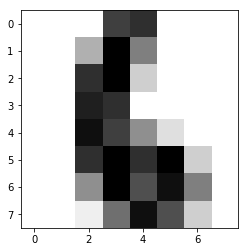

In [61]:
plt.imshow(images[6], cmap = plt.cm.gray_r, interpolation = 'nearest')
plt.show()

#### Testing Our Best Fitted Model
We will try to predict 2 digits and see how our model works.

3


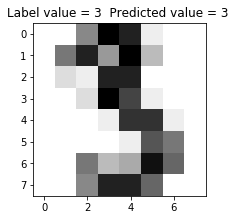

5


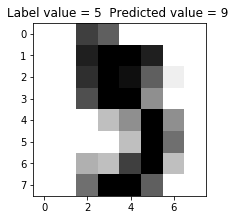

In [63]:
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()